In [42]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
# from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('titanic_data.csv')

# Feature engineering: Extract title from the "Name" column
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)


# Split data into attributes and target
attributes = df.drop('Survived', axis=1)
target = df['Survived']

# Identify numerical and categorical columns
numeric_features = attributes.select_dtypes(include=['int64', 'float64']).columns
categorical_features = attributes.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



# Define the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_model)
])

# Split data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(attributes, target, test_size=0.3, random_state=42)




# Separate majority and minority classes
majority_class = xtrain[ytrain == 0]
minority_class = xtrain[ytrain == 1]

# Randomly sample the majority class to match the number of the minority class
majority_sample = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the two to form a new balanced dataset
balanced_xtrain = pd.concat([majority_sample, minority_class])
balanced_ytrain = pd.concat([pd.Series([0] * len(majority_sample)), pd.Series([1] * len(minority_class))])

# Fit pipeline with the new under-sampled data
pipeline.fit(balanced_xtrain, balanced_ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [43]:
# Evaluate the model
accuracy = pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")


Accuracy on test set: 0.82


In [ ]:
y_pred = pipeline.predict(xtest)

results_df = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred
})

print("Actual vs Predicted Values:")
print(results_df)

Actual vs Predicted Values:
     Actual  Predicted
709       1          0
439       0          0
840       0          0
720       1          1
39        1          0
..      ...        ...
821       1          0
633       0          0
456       0          0
500       0          0
430       1          0

[268 rows x 2 columns]


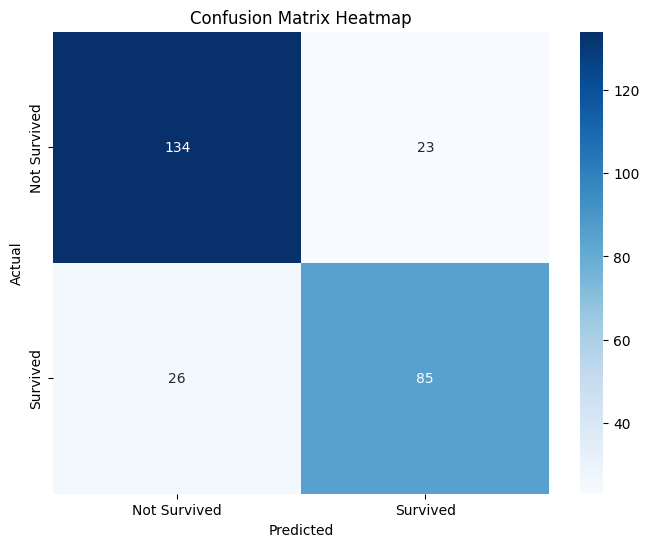

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(ytest, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


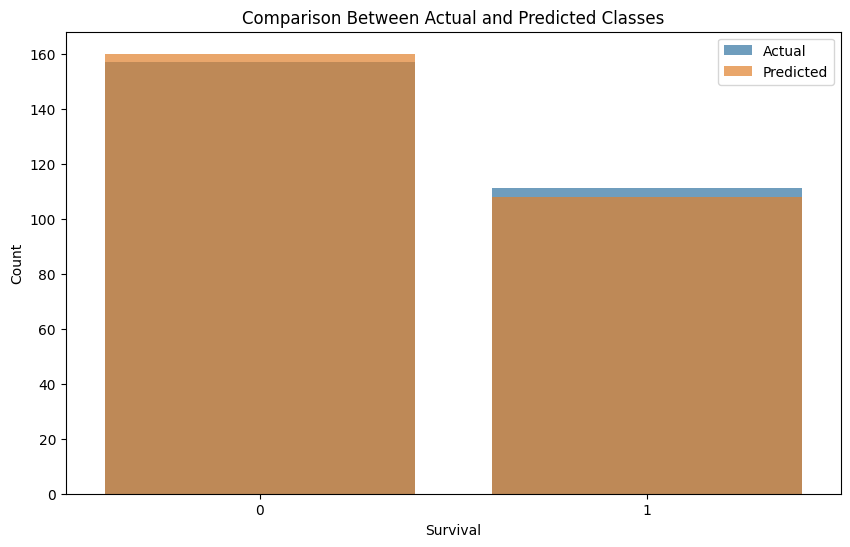

In [40]:
# Create a DataFrame for visualization
results_df = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})

plt.figure(figsize=(10, 6))
sns.countplot(x='Actual', data=results_df, alpha=0.7, label="Actual")
sns.countplot(x='Predicted', data=results_df, alpha=0.7, label="Predicted")
plt.xlabel('Survival')
plt.ylabel('Count')
plt.title('Comparison Between Actual and Predicted Classes')
plt.legend()
plt.show()



In [34]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(ytest, pipeline.predict(xtest))
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       157
           1       0.79      0.77      0.78       111

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



In [36]:

# Prediction for multiple unseen samples entered manually
def predict_unseen_sample():
    """
    Accepts multiple manual inputs from the user, preprocesses them, and makes predictions.
    Allows the user to specify the number of samples they will test with.
    """
    try:
        # Ask user how many unseen samples they want to test with
        num_samples = int(input("\nHow many unseen samples would you like to test with? "))

        for i in range(num_samples):
            print(f"\nInput data for sample {i + 1}:")
            # Input prompts for each unseen sample
            pclass = int(input("Pclass (1, 2, 3): "))
            name = input("Name (e.g., John Smith): ")
            sex = input("Sex (male/female): ")
            age = float(input("Age (e.g., 28): "))
            sibsp = int(input("Siblings/Spouses aboard (e.g., 0, 1): "))
            parch = int(input("Parents/Children aboard (e.g., 0, 1): "))
            fare = float(input("Fare (e.g., 50): "))
            embarked = input("Embarked (S, C, Q): ")

            # Create a dictionary for the user-provided input
            manual_input = {
                "Pclass": pclass,
                "Name": name,
                "Sex": sex,
                "Age": age,
                "SibSp": sibsp,
                "Parch": parch,
                "Fare": fare,
                "Embarked": embarked,
                # Include missing expected columns with default values
                "PassengerId": 0,
                "Ticket": 0,
                "Cabin": 0
            }

            # Convert dictionary to DataFrame
            unseen_df = pd.DataFrame([manual_input])

            # Feature engineering - ensure the 'Title' feature is added to unseen data
            unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

            # Pass the preprocessed unseen sample into the pipeline
            prediction = pipeline.predict(unseen_df)

            # Output the prediction
            unseen_df['Survived_Prediction'] = prediction
            print("\nPrediction made successfully!")
            print(unseen_df[['Name', 'Survived_Prediction']])

    except Exception as e:
        print("\nError predicting unseen sample:", e)

In [27]:

predict_unseen_sample()


Input data for sample 1:

Prediction made successfully!
            Name  Survived_Prediction
0  wwwwwwwwwwwww                    0

Input data for sample 2:

Prediction made successfully!
   Name  Survived_Prediction
0  john                    1


In [41]:
# Prediction for unseen sample
def predict_unseen_sample(file_path):
  
    # Load the unseen sample
    try:
        unseen_df = pd.read_csv(file_path)
        print("Sample loaded successfully!")

        # Feature engineering - ensure the 'Title' feature is added to unseen data
        unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

        # Drop rows with missing values in critical features if necessary
        unseen_df.dropna(subset=['Age', 'Fare', 'Sex'], inplace=True)

        # Pass the preprocessed unseen sample into the pipeline
        prediction = pipeline.predict(unseen_df)

        # Output the prediction
        unseen_df['Survived_Prediction'] = prediction
        print("Prediction made successfully!")
        print(unseen_df[['Name', 'Survived_Prediction']])
    except Exception as e:
        print("Error loading or predicting unseen sample:", e)




In [ ]:
# Example usage - pass the path to your unseen sample here
unseen_file_path = 'unseen_sample.csv'  # Replace with actual file path
predict_unseen_sample(unseen_file_path)